In [1]:
import pyro
import numpy as np
import scanpy as sc
import json
import pandas as pd
import os
import pyro.distributions as dist
import torch
from sklearn.neighbors import KernelDensity
import scipy
import utils
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from collections import defaultdict
import os
import logging
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

In [2]:
import torch.distributions.transforms as transforms

In [266]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [16]:
infer = pd.read_csv("N_infer_full_10.16.21", index_col=0)

In [3]:
adata = sc.read_h5ad("N_ribas310_clones.h5")

In [17]:
infer

,NOC2L,SDF4,INTS11,CCNL2,MRPL20,SSU72,SLC35E2B,CDK11A,NADK,GNB1,...,ZBED4,CRELD2,PIM3,TRABD,SELENOO,PLXNB2,PPP6R2,SBF1,LMF2,CHKB
GGACAGAAGAAGGGTA-1-3,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,...,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009
TCAATCTCACTTGGAT-1-3,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,...,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009
TTGCCGTAGTTACGGG-1-3,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,...,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009
AACTCAGGTAATTGGA-1-3,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,...,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009
CGAGCCAAGTTAACGA-1-3,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,...,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009,1.001009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTCTCGAGTTTCCTT-1-5,1.152337,1.147714,1.144628,1.141370,1.138487,1.133845,1.132396,1.131183,1.128991,1.128063,...,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472
CCATTCGGTATGGTTC-1-5,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,...,1.115009,1.119440,1.121412,1.123560,1.126064,1.131157,1.134042,1.133940,1.133943,1.133894
GTGCATATCAAAGACA-1-5,1.163315,1.155507,1.141342,1.137278,1.130978,1.118832,1.113311,1.108189,1.098612,1.094177,...,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472
ACAGCCGTCCGCGTTT-1-5,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,...,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472,1.001472


In [19]:
adata_subsampled, infer_subsampled = utils.format_data(adata, infer, 200, 200)

Trying to set attribute `.uns` of view, copying.


In [20]:
mixture_mu=np.zeros(infer_subsampled.shape)
mu = [.9109, 1.001, 1.1167]
for i in range(infer_subsampled.shape[0]):
    for j in range(infer_subsampled.shape[1]):
        if infer_subsampled[i][j]<.95:
            mixture_mu[i][j]=mu[0]
        elif infer_subsampled[i][j]>.95 and infer_subsampled[i][j]<1.05:
            mixture_mu[i][j]=mu[1]
        else:
            mixture_mu[i][j]=mu[2]
            

In [21]:
adata_tensor=torch.tensor(adata_subsampled.X.astype("int"))

In [274]:
infer_sub_tensor = torch.tensor(infer_subsampled)

infer_sub_tensor_small = torch.flatten(infer_sub_tensor).to(torch.float)
infer_tensor_big =  torch.flatten(torch.tensor(infer.to_numpy())).to(torch.float)

data= infer_tensor_big[0:len(infer_tensor_big)//2]

In [275]:
K = 3  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
        scale = pyro.sample('scale', dist.LogNormal(0., 2.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale[assignment]), obs=data)

In [276]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [277]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "scale":
        sig = (data.var() / 2).sqrt()
        return torch.tensor([sig,sig,sig])
    if site["name"] == "locs":
        return torch.tensor([.9,1.01,1.2])
    raise ValueError(site["name"])
    
def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']),
                             init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 0, initial_loss = -33554424.0


In [278]:
 # Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

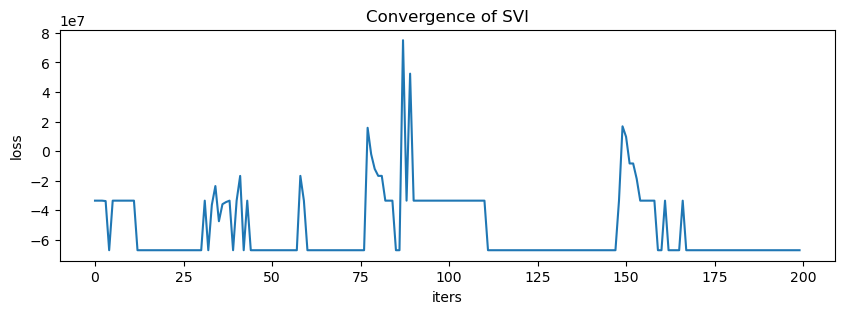

In [281]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.title('Convergence of SVI');

In [282]:
pyro.get_param_store().named_parameters()

dict_items([('AutoDelta.weights', Parameter containing:
tensor([ 2.3177, -2.0559, -2.0370], requires_grad=True)), ('AutoDelta.locs', Parameter containing:
tensor([1.0081, 0.4694, 0.9009], requires_grad=True)), ('AutoDelta.scale', Parameter containing:
tensor([-3.0749, -4.4049, -4.2369], requires_grad=True))])

In [283]:
for weight in [ 2.3177, -2.0559, -2.0370]:
    print(np.exp(weight))

10.152297149205193
0.1279776038875509
0.13041938272582848


In [245]:
data = []
for i in range(10):
    data.append(abs(np.random.normal(10,5,5)))

In [246]:
data=torch.tensor(np.asarray(data).astype("int"))

In [180]:
def model(data):
    mixture_mu=np.zeros(infer_subsampled.shape)
    mu = [.9109, 1.001, 1.1167]
    for i in range(infer_subsampled.shape[0]):
        for j in range(infer_subsampled.shape[1]):
            if infer_subsampled[i][j]<.95:
                mixture_mu[i][j]=mu[0]
            elif infer_subsampled[i][j]>.95 and infer_subsampled[i][j]<1.05:
                mixture_mu[i][j]=mu[1]
            else:
                mixture_mu[i][j]=mu[2]
    mixture_mu=torch.tensor(mixture_mu)
    a=0.3
    ap=1.0
    std_1 = torch.std(torch.sum(data, axis=1).float())
    bp = float(torch.mean(torch.sum(data,axis=1).float())/std_1)
    c=0.3
    C=data.shape[0]
    G=data.shape[1]
    eta_sigma=.5
    
    with pyro.plate("xis", C):
        xi = pyro.sample("xi",dist.TransformedDistribution(dist.Gamma(ap,bp),transforms.ExpTransform()))
        theta = pyro.sample("theta",dist.TransformedDistribution(dist.Gamma(a, xi),transforms.ExpTransform()))
        print(theta)
    
    with pyro.plate("ets",G):
        with pyro.plate("betas",C):
            eta = pyro.sample("eta", dist.TransformedDistribution(dist.Normal(mixture_mu, eta_sigma),transforms.ExpTransform()))
            beta = pyro.sample("beta", dist.TransformedDistribution(dist.Gamma(c, eta),transforms.ExpTransform()))
            print(beta)

    with pyro.plate("ets2", G):
        with pyro.plate("betas2", C):
            X = pyro.sample("X", dist.Poisson(torch.tensor(torch.tile(theta,(G,1)).T)*beta),obs=data) 
    #param_store = pyro.get_param_store()
    #param_store.__setitem__('theta',theta)
    #param_store.__setitem__('beta',beta)
    #param_store.__setitem__('xi',xi)       
    return theta,beta


In [163]:
def model(data):
    mixture_mu=np.zeros(infer_subsampled.shape)
    mu = [.9109, 1.001, 1.1167]
    for i in range(infer_subsampled.shape[0]):
        for j in range(infer_subsampled.shape[1]):
            if infer_subsampled[i][j]<.95:
                mixture_mu[i][j]=mu[0]
            elif infer_subsampled[i][j]>.95 and infer_subsampled[i][j]<1.05:
                mixture_mu[i][j]=mu[1]
            else:
                mixture_mu[i][j]=mu[2]
    mixture_mu=torch.tensor(mixture_mu)
    a=0.3
    ap=1.0
    std_1 = torch.std(torch.sum(data, axis=1).float())
    bp = float(torch.mean(torch.sum(data,axis=1).float())/std_1)
    c=0.3
    C=data.shape[0]
    G=data.shape[1]
    eta_sigma=.5
    
    with pyro.plate("xis", C):
        xi = torch.exp(pyro.sample("xi",dist.Gamma(ap,bp)))
        theta = torch.exp(pyro.sample("theta",dist.Gamma(a, xi)))
    
    with pyro.plate("ets",G):
        with pyro.plate("betas",C):
            eta = torch.exp(pyro.sample("eta", dist.Normal(mixture_mu, eta_sigma)))
            beta = torch.exp(pyro.sample("beta", dist.Gamma(c, eta)))


    with pyro.plate("ets2", G):
        with pyro.plate("betas2", C):
            X = pyro.sample("X", dist.Poisson(torch.tensor(torch.tile(theta,(G,1)).T)*beta),obs=data) 
    param_store = pyro.get_param_store()
    param_store.__setitem__('theta',theta)
    param_store.__setitem__('beta',beta)
    param_store.__setitem__('xi',xi)       
    return theta,beta

In [140]:
def guide(data):
    mixture_mu=np.zeros(infer_subsampled.shape)
    mu = [.9109, 1.001, 1.1167]
    for i in range(infer_subsampled.shape[0]):
        for j in range(infer_subsampled.shape[1]):
            if infer_subsampled[i][j]<.95:
                mixture_mu[i][j]=mu[0]
            elif infer_subsampled[i][j]>.95 and infer_subsampled[i][j]<1.05:
                mixture_mu[i][j]=mu[1]
            else:
                mixture_mu[i][j]=mu[2]
    mixture_mu=torch.tensor(mixture_mu)
    '''
    C=data.shape[0]
    G=data.shape[1]
    a_q = pyro.param("a_q",torch.tensor(a), constraint=dist.constraints.positive)
    ap_q = pyro.param("ap_q",torch.tensor(ap), constraint=dist.constraints.positive)
    bp_q = pyro.param("bp_q",torch.tensor(bp), constraint=dist.constraints.positive)
    c_q = pyro.param("c_q",torch.tensor(c), constraint=dist.constraints.positive)
    eta_sig_q = pyro.param("eta_sig_q",torch.tensor(eta_sigma), constraint=dist.constraints.positive)
    '''
    a_q=0.3
    ap_q=1.0
    std_1 = torch.std(torch.sum(data, axis=1).float())
    bp_q = float(torch.mean(torch.sum(data,axis=1).float())/std_1)
    c_q=0.3
    C=data.shape[0]
    G=data.shape[1]
    eta_sig_q=.5

    with pyro.plate("xis", C):
        xi = pyro.sample("xi",dist.TransformedDistribution(dist.Gamma(ap_q,bp_q),transforms.ExpTransform()))
        theta = pyro.sample("theta",dist.TransformedDistribution(dist.Gamma(a_q, xi),transforms.ExpTransform()))
    #xi = pyro.sample("xi",dist.TransformedDistribution(dist.Gamma(a_q,b_q),transforms.AbsTransform()))
    with pyro.plate("ets",G):
        with pyro.plate("betas",C):
        
            eta = pyro.sample("eta", dist.TransformedDistribution(dist.Normal(mixture_mu, eta_sig_q),transforms.ExpTransform()))
            beta = pyro.sample("beta", dist.TransformedDistribution(dist.Gamma(c_q, eta),transforms.ExpTransform()))
        
    with pyro.plate("ets2", G):
        with pyro.plate("betas2", C):
            pyro.sample("X",dist.Poisson(torch.tensor(torch.tile(theta,(G,1)).T)*beta))
      

    

In [145]:
def guide(data):
    mixture_mu=np.zeros(infer_subsampled.shape)
    mu = [.9109, 1.001, 1.1167]
    for i in range(infer_subsampled.shape[0]):
        for j in range(infer_subsampled.shape[1]):
            if infer_subsampled[i][j]<.95:
                mixture_mu[i][j]=mu[0]
            elif infer_subsampled[i][j]>.95 and infer_subsampled[i][j]<1.05:
                mixture_mu[i][j]=mu[1]
            else:
                mixture_mu[i][j]=mu[2]
    mixture_mu=torch.tensor(mixture_mu)
    '''
    C=data.shape[0]
    G=data.shape[1]
    a_q = pyro.param("a_q",torch.tensor(a), constraint=dist.constraints.positive)
    ap_q = pyro.param("ap_q",torch.tensor(ap), constraint=dist.constraints.positive)
    bp_q = pyro.param("bp_q",torch.tensor(bp), constraint=dist.constraints.positive)
    c_q = pyro.param("c_q",torch.tensor(c), constraint=dist.constraints.positive)
    eta_sig_q = pyro.param("eta_sig_q",torch.tensor(eta_sigma), constraint=dist.constraints.positive)
    '''
    a_q=0.3
    ap_q=1.0
    std_1 = torch.std(torch.sum(data, axis=1).float())
    bp_q = float(torch.mean(torch.sum(data,axis=1).float())/std_1)
    c_q=0.3
    C=data.shape[0]
    G=data.shape[1]
    eta_sig_q=.5

    with pyro.plate("xis", C):
        xi = torch.exp(pyro.sample("xi",dist.Gamma(ap_q,bp_q)))
        theta = torch.exp(pyro.sample("theta",dist.Gamma(a_q, xi)))
    #xi = pyro.sample("xi",dist.TransformedDistribution(dist.Gamma(a_q,b_q),transforms.AbsTransform()))
    with pyro.plate("ets",G):
        with pyro.plate("betas",C):
        
            eta = torch.exp(pyro.sample("eta", dist.Normal(mixture_mu, eta_sig_q)))
            beta = torch.exp(pyro.sample("beta", dist.Gamma(c_q, eta)))
        
    with pyro.plate("ets2", G):
        with pyro.plate("betas2", C):
            pyro.sample("X",dist.Poisson(torch.tensor(torch.tile(theta,(G,1)).T)*beta))

In [136]:
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


In [181]:
from pyro.infer.autoguide import AutoNormal
my_autoguide = AutoDelta(model)

# set up the optimizer
adam_params = {"lr": 0.005}
optimizer = Adam(adam_params)

pyro.clear_param_store()
my_svi = SVI(model=model,
             guide=my_autoguide,
             optim=optimizer,
             loss=Trace_ELBO())

# Optimize
print("Optimizing...")
optimization_steps = 1000
losses=[]
for i in range(optimization_steps):
    
    loss = my_svi.step(adata_tensor)
    losses.append(loss)

Optimizing...
tensor([1.0056, 1.0181, 1.0127, 1.0179, 1.0055, 1.0224, 1.0150, 1.0367, 1.0738,
        1.0053, 1.0341, 1.1934, 1.0873, 1.0673, 1.0539, 1.0323, 1.0045, 1.0298,
        1.0292, 1.0336, 1.1584, 1.0214, 1.1045, 1.0132, 1.0167, 1.0759, 1.0409,
        1.0750, 1.0872, 1.0086, 1.0144, 1.0372, 1.0189, 1.0303, 1.0257, 1.0383,
        1.0326, 1.0446, 1.0914, 1.0272, 1.1038, 1.0589, 1.0189, 1.0090, 1.0064,
        1.0082, 1.0130, 1.0584, 1.0847, 1.0809, 1.0122, 1.0074, 1.0098, 1.1350,
        1.3660, 1.0066, 1.0025, 1.0045, 1.0085, 1.0464, 1.0110, 1.0270, 1.0207,
        1.0042, 1.0116, 1.0221, 1.0124, 1.0098, 1.0098, 1.0473, 1.0157, 1.0122,
        1.0057, 1.0175, 1.0394, 1.0388, 1.0672, 1.0256, 1.0446, 1.0196, 1.0190,
        1.0282, 1.0611, 1.0838, 1.0031, 1.0468, 1.0550, 1.0501, 1.0169, 1.0209,
        1.0386, 1.0268, 1.1119, 1.0398, 1.0155, 1.0147, 1.0738, 1.0425, 1.0063,
        1.0919, 1.0512, 1.0337, 1.0372, 1.0176, 1.1168, 1.0069, 1.0594, 1.0601,
        1.0366, 1.0282, 1.

/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([1.0006, 1.0130, 1.0077, 1.0128, 1.0004, 1.0173, 1.0099, 1.0315, 1.0685,
        1.0003, 1.0290, 1.1874, 1.0819, 1.0619, 1.0486, 1.0271, 0.9995, 1.0247,
        1.0241, 1.0284, 1.1526, 1.0163, 1.0990, 1.0081, 1.0116, 1.0706, 1.0357,
        1.0696, 1.0818, 1.0036, 1.0093, 1.0321, 1.0139, 1.0252, 1.0206, 1.0331,
        1.0274, 1.0394, 1.0859, 1.0221, 1.0983, 1.0537, 1.0138, 1.0040, 1.0014,
        1.0031, 1.0079, 1.0532, 1.0793, 1.0756, 1.0071, 1.0024, 1.0047, 1.1293,
        1.3592, 1.0016, 0.9975, 0.9995, 1.0035, 1.0412, 1.0059, 1.0218, 1.0156,
        0.9992, 1.0066, 1.0170, 1.0073, 1.0048, 1.0048, 1.0421, 1.0107, 1.0072,
        1.0007, 1.0124, 1.0342, 1.0336, 1.0619, 1.0205, 1.0394, 1.0145, 1.0139,
        1.0231, 1.0558, 1.0784, 0.9981, 1.0415, 1.0498, 1.0448, 1.0119, 1.0158,
        1.0335, 1.0217, 1.1064, 1.0346, 1.0104, 1.0097, 1.0684, 1.0373, 1.0013,
        1.0865, 1.0460, 1.0285, 1.0320, 1.0125, 1.1113, 1.0019, 1.0541, 1.0548,
        1.0315, 1.0231, 0.9977, 1.0205, 

ValueError: Error while computing log_prob at site 'theta':
Expected value argument (Tensor of shape (800,)) to be within the support (GreaterThan(lower_bound=0.0)) of the distribution Gamma(concentration: torch.Size([800]), rate: torch.Size([800])), but found invalid values:
tensor([ 6.2875e-04,  1.2931e-02,  7.6437e-03,  1.2745e-02,  4.4825e-04,
         1.7167e-02,  9.8655e-03,  3.1017e-02,  6.6243e-02,  2.8296e-04,
         2.8540e-02,  1.7177e-01,  7.8679e-02,  6.0104e-02,  4.7467e-02,
         2.6754e-02, -5.4046e-04,  2.4409e-02,  2.3815e-02,  2.8037e-02,
         1.4202e-01,  1.6184e-02,  9.4376e-02,  8.0806e-03,  1.1544e-02,
         6.8194e-02,  3.5098e-02,  6.7317e-02,  7.8629e-02,  3.5773e-03,
         9.3057e-03,  3.1567e-02,  1.3767e-02,  2.4865e-02,  2.0417e-02,
         3.2568e-02,  2.7040e-02,  3.8612e-02,  8.2422e-02,  2.1863e-02,
         9.3769e-02,  5.2272e-02,  1.3705e-02,  3.9634e-03,  1.3587e-03,
         3.1337e-03,  7.9053e-03,  5.1802e-02,  7.6298e-02,  7.2835e-02,
         7.1234e-03,  2.3951e-03,  4.7252e-03,  1.2161e-01,  3.0689e-01,
         1.5842e-03, -2.5239e-03, -5.2991e-04,  3.4910e-03,  4.0355e-02,
         5.9146e-03,  2.1603e-02,  1.5521e-02, -8.0475e-04,  6.5447e-03,
         1.6847e-02,  7.2797e-03,  4.7925e-03,  4.7685e-03,  4.1208e-02,
         1.0605e-02,  7.1567e-03,  6.6175e-04,  1.2348e-02,  3.3631e-02,
         3.3064e-02,  6.0039e-02,  2.0282e-02,  3.8603e-02,  1.4412e-02,
         1.3806e-02,  2.2837e-02,  5.4277e-02,  7.5494e-02, -1.9291e-03,
         4.0696e-02,  4.8556e-02,  4.3855e-02,  1.1802e-02,  1.5713e-02,
         3.2912e-02,  2.1487e-02,  1.0107e-01,  3.3985e-02,  1.0341e-02,
         9.6199e-03,  6.6188e-02,  3.6586e-02,  1.2704e-03,  8.2944e-02,
         4.4950e-02,  2.8114e-02,  3.1511e-02,  1.2434e-02,  1.0549e-01,
         1.9231e-03,  5.2692e-02,  5.3328e-02,  3.0972e-02,  2.2820e-02,
        -2.3392e-03,  2.0254e-02,  3.9349e-02,  1.0454e-03,  3.9649e-02,
         3.0638e-02,  1.7718e-02,  3.9694e-02,  9.7342e-03,  1.1332e-02,
         1.4535e-02,  3.3557e-03,  2.5994e-02,  1.2488e-02,  2.1235e-02,
         2.0351e-02,  5.7344e-03,  2.5106e-02,  3.0052e-02,  1.7998e-02,
         2.4086e-02,  1.5309e-02,  1.0645e-01,  3.2132e-02,  7.3944e-02,
         3.7990e-03,  3.7901e-03,  9.8656e-02,  7.6479e-02,  4.1220e-02,
         5.4296e-02,  5.8085e-02,  2.5971e-02,  4.7497e-02,  3.1526e-03,
        -3.5226e-03,  3.8092e-02,  1.5585e-01,  6.8404e-02,  7.5445e-02,
         1.9861e-03,  9.4770e-02,  1.2770e-01,  7.7737e-03,  3.1569e-02,
         3.4832e-02,  8.9838e-03,  3.4226e-02,  1.9575e-02, -4.0710e-03,
         1.9806e-02,  5.5085e-02,  6.1585e-02,  6.9272e-02,  1.2437e-02,
         6.1102e-02,  1.4496e-02,  1.1143e-02,  2.1608e-02,  1.4355e-01,
         4.6638e-02,  8.7684e-03,  3.4060e-02, -1.8622e-04,  4.0896e-02,
         1.7623e-02,  2.9104e-02,  2.7229e-02,  1.7040e-01,  7.8587e-03,
         9.5851e-02,  1.1435e-02,  2.6454e-03,  1.2877e-02,  5.9387e-03,
         5.8810e-02,  3.6698e-04,  1.7968e-03,  1.7603e-02,  2.7086e-02,
         1.4789e-01,  5.9188e-02, -3.6286e-03,  2.0767e-03,  1.4380e-01,
         1.8525e-02,  3.5867e-02,  7.7672e-03,  6.0333e-03,  4.4401e-02,
         1.3754e-02,  1.3027e-02,  2.1192e-01,  1.9877e-03,  8.4411e-02,
         5.5854e-02,  8.4570e-02,  1.1370e-02, -1.8519e-03,  2.1628e-02,
         5.5395e-03,  4.2376e-03,  7.4164e-02, -1.0992e-03,  3.0422e-02,
         6.3314e-02,  2.6271e-02,  2.5407e-02,  1.9402e-02,  5.4764e-02,
         7.2301e-02,  4.1323e-02,  1.9659e-02,  2.4645e-02,  5.6897e-02,
         2.4698e-02,  2.4635e-02,  2.7025e-02,  3.2598e-02,  1.6337e-02,
         2.7843e-04,  4.9981e-02,  1.1932e-01,  2.5378e-02,  4.1061e-02,
        -1.0258e-03,  4.7277e-02,  1.1254e-02,  2.8028e-02,  2.8657e-03,
         8.1263e-02,  1.1562e-02,  1.4166e-02, -4.9383e-04,  1.0402e-02,
         3.0759e-02,  4.7304e-02,  3.5026e-02,  2.6752e-02,  4.7137e-02,
         1.9520e-01,  9.0467e-02,  4.3266e-03,  3.4243e-04,  1.5226e-02,
        -1.3217e-03,  2.7690e-02,  1.5005e-02,  1.2938e-02,  1.0333e-02,
         7.3796e-02,  1.2315e-02,  6.0391e-02,  2.7724e-03,  1.5145e-01,
         3.5575e-03,  5.8169e-03,  8.2893e-03,  3.2799e-02,  8.8257e-03,
         3.0510e-01,  7.0369e-03,  2.2828e-02,  8.7314e-02,  3.4336e-03,
         1.0566e-02,  6.5142e-02,  7.7350e-02,  3.1170e-02,  3.9955e-03,
         2.1033e-03,  2.5736e-03,  2.6507e-02,  5.5410e-03,  3.6306e-02,
         4.8087e-02,  7.2806e-03,  1.1827e-02,  6.6746e-02,  1.6812e-02,
         1.0290e-01,  5.1898e-02,  3.8050e-02,  8.3870e-03,  1.2774e-02,
         1.8556e-02,  2.6916e-02,  9.5258e-02,  5.7291e-02,  7.7493e-03,
         2.8157e-02,  3.6237e-02,  1.2465e-02,  6.5158e-02,  2.6842e-04,
         4.4715e-02,  4.1010e-03,  2.9929e-02,  8.3761e-02,  3.7691e-02,
         4.2486e-02,  7.8525e-02,  3.4996e-02,  4.5816e-02,  2.3453e-02,
         7.4516e-03,  3.9040e-02,  6.0595e-02,  1.6375e-02,  2.4859e-02,
         4.2806e-02,  9.0925e-03,  9.5987e-02,  2.7359e-02,  2.1921e-03,
         3.2500e-02,  1.2332e-02,  2.0997e-03,  8.1935e-04,  1.1067e-02,
         4.9186e-02,  2.0268e-02,  8.7916e-03,  1.8818e-02,  8.2472e-03,
         6.0648e-02,  3.8598e-02,  1.2640e-02,  5.3874e-02,  2.3718e-02,
         1.8863e-02,  1.2726e-02, -2.9556e-03,  1.3436e-02,  1.1762e-02,
         7.3539e-03,  2.6958e-02,  2.0764e-02,  1.7462e-02,  2.5586e-02,
         3.7391e-02,  1.5600e-02,  2.9784e-02,  1.7687e-02,  8.0915e-03,
         7.2877e-03,  6.8538e-03,  2.8574e-03,  3.0663e-02,  1.9893e-03,
         1.4285e-02,  1.1732e-02,  4.4948e-03,  1.2270e-02,  1.6856e-02,
         1.5940e-02,  1.4610e-03,  8.5324e-02,  1.3801e-02,  2.5589e-02,
         1.5937e-01,  8.6468e-02,  1.7531e-02,  5.8585e-02,  5.3362e-02,
         5.6528e-02, -2.8435e-04,  1.6440e-02,  2.3308e-02,  3.6902e-02,
        -1.7384e-03,  1.8952e-02,  1.0676e-02,  4.1620e-03,  1.0835e-01,
         1.0997e-02,  1.3426e-01,  1.8178e-03,  2.2051e-02, -2.5067e-04,
         2.6471e-02,  1.4083e-01,  3.1611e-02,  4.5506e-02,  1.7276e-02,
         2.9238e-02,  1.5753e-02, -4.2895e-03,  5.1584e-02,  4.6052e-02,
         2.0606e-02,  9.4736e-03,  2.0402e-02, -2.9429e-03,  3.9630e-02,
         7.5683e-03,  1.6758e-02,  8.4613e-03,  3.8509e-03,  9.6093e-03,
         5.3997e-02,  1.4483e-02,  1.5983e-02,  3.6286e-02,  8.5571e-02,
         1.0167e-01,  2.9193e-02,  2.3424e-02,  1.4059e-03,  1.4889e-02,
         1.3969e-02, -3.8760e-03,  3.5441e-03,  1.9268e-02,  8.0178e-02,
         8.5926e-02,  1.7012e-02, -7.0400e-04,  2.1077e-02,  5.9254e-02,
        -3.3578e-03,  6.5222e-02,  6.9858e-02,  9.5760e-03,  6.7139e-02,
         4.1448e-02,  4.1392e-03, -3.0696e-03, -3.6380e-03,  8.8262e-02,
         3.3298e-02,  1.1155e-02,  9.6360e-03,  1.3912e-02,  4.9993e-02,
         2.9401e-02,  1.2251e-01,  6.7912e-02,  1.8865e-02,  3.8444e-02,
         6.9805e-02,  4.7446e-03,  1.0421e-01,  7.8833e-02,  9.2761e-02,
         2.5722e-03,  1.1405e-02,  8.3005e-02,  1.5042e-02,  9.9007e-03,
        -4.6280e-03,  4.0294e-02,  2.4384e-02,  6.2834e-02,  2.3436e-03,
         3.3007e-02,  3.1523e-02,  3.9676e-02,  8.2597e-03,  2.1883e-02,
         1.8124e-02,  4.2898e-03,  4.4658e-02,  5.5401e-03,  1.9388e-03,
         5.9798e-02,  8.2646e-03,  9.5155e-03,  3.6781e-02,  5.3896e-02,
         3.6491e-02,  2.7464e-02,  1.0110e-01,  2.5286e-02,  1.5962e-03,
         3.2821e-02,  1.6257e-02,  3.7157e-02,  9.5381e-02,  1.1474e-02,
         1.4369e-02,  1.0751e-02,  8.6336e-02,  1.1055e-01,  1.0209e-02,
         1.4139e-02,  3.1567e-02,  7.5812e-02,  5.1116e-02,  4.7214e-02,
         3.8696e-02,  1.6503e-03,  2.5958e-02,  6.9128e-02,  3.0856e-02,
         3.6298e-02,  1.7646e-02,  4.6838e-03, -2.7979e-03,  1.7763e-01,
         3.5316e-03,  3.5607e-02,  1.9865e-02,  4.7295e-02,  2.9981e-02,
         2.6651e-02,  3.2014e-02,  2.4343e-02,  1.0671e-01,  1.5740e-02,
         2.4252e-02,  1.9933e-02,  2.2138e-02,  3.8485e-04,  3.4090e-02,
         8.7388e-03,  2.0656e-02,  1.0430e-01,  9.8473e-02,  4.9889e-04,
         1.7948e-02,  4.7430e-03,  1.6056e-04,  1.5788e-02,  6.5407e-02,
         1.2967e-02,  9.2472e-02,  7.0773e-02,  3.2241e-04,  1.1138e-02,
         3.8958e-02,  4.3755e-02,  4.4116e-02,  2.3349e-02,  1.4302e-02,
        -3.5399e-03,  5.9762e-02,  4.9046e-03,  5.2750e-02,  3.6410e-03,
         7.1343e-03,  9.4412e-02,  2.8504e-02,  2.5356e-02,  4.2822e-02,
         5.6942e-02,  6.0716e-03,  1.2757e-02,  7.0334e-02,  7.1146e-03,
         8.3593e-03,  1.7874e-02,  4.3985e-02, -1.2619e-03,  1.3979e-02,
         5.3700e-02,  1.4645e-02,  3.7058e-02,  5.0390e-03,  2.0475e-02,
         3.0395e-02,  2.9795e-03,  9.6920e-02,  1.5921e-02,  6.9925e-03,
         3.4295e-02,  8.4444e-03,  5.4989e-02,  6.0793e-02,  5.9870e-03,
         7.0094e-04,  6.1731e-04,  1.0909e-01,  5.8318e-02,  1.2638e-02,
         8.0665e-03,  5.6637e-02,  5.9974e-03,  9.3635e-03,  6.4444e-03,
         3.1128e-03, -5.2132e-04,  1.6536e-01,  5.5801e-03,  3.2784e-02,
         6.4514e-02,  4.8845e-02,  4.6498e-02,  2.6591e-03,  1.9878e-02,
         1.0343e-02,  2.9465e-02,  4.1292e-02,  4.1228e-02,  5.7492e-02,
        -2.6256e-03,  5.0603e-04,  7.8608e-02,  3.9417e-02,  6.7266e-03,
         6.7370e-02,  3.8562e-02,  4.6846e-02,  8.6051e-03,  5.8233e-03,
         1.2267e-01,  1.1093e-02,  6.0884e-03,  9.3791e-03,  1.5161e-02,
         3.1340e-02,  1.4194e-01,  6.1641e-02,  5.4761e-02,  1.0549e-01,
         5.2420e-02,  2.1223e-03,  2.8070e-02,  3.8987e-02,  4.5532e-03,
         4.4385e-02,  3.0018e-02,  8.9395e-02,  8.8445e-03,  7.8717e-03,
         2.6693e-02, -5.8066e-04, -5.6110e-04,  1.2288e-02,  2.0940e-02,
         4.8151e-03,  5.3978e-02,  1.3462e-02,  1.9308e-02,  6.8226e-02,
         5.7302e-02,  4.7932e-02,  3.6353e-02,  1.2611e-01,  6.9428e-03,
         1.8350e-03,  5.4360e-03,  2.4460e-03,  4.9987e-02,  3.2207e-02,
         9.3992e-02,  1.6654e-02,  9.4567e-03,  3.6303e-02,  3.3475e-02,
         7.8340e-02,  1.0897e-03,  2.1388e-02,  6.3339e-02,  1.0384e-02,
         4.3612e-03,  1.5301e-01,  9.1979e-02,  1.5842e-02, -7.3675e-04,
         2.1061e-02,  5.7106e-02,  7.7692e-02,  2.0679e-02,  1.1461e-01,
         1.7236e-02,  1.6258e-02,  4.8116e-02, -1.4877e-03,  1.4059e-02,
         5.4674e-02,  7.3534e-03, -2.9197e-03,  1.2427e-02,  1.2087e-02,
         7.7889e-03,  4.4446e-02,  5.4227e-02,  3.4919e-03,  4.4275e-02,
         6.0406e-02,  4.4198e-02,  8.6651e-02,  4.8221e-02,  7.8382e-03,
         1.0329e-03, -3.2569e-03,  2.8090e-02,  1.3640e-02,  2.9842e-02,
         3.3334e-03,  4.9326e-02,  1.0189e-01,  6.5888e-02,  5.9937e-03,
        -3.8947e-04,  8.3985e-03,  5.8646e-02,  9.3488e-04,  4.6319e-03,
         1.5595e-02,  4.2260e-02,  2.8632e-02,  3.6728e-02,  4.6647e-02,
         5.7114e-02,  2.1931e-02,  9.5044e-03,  2.3293e-02,  6.5380e-02,
         1.4654e-02,  4.6816e-02,  2.0785e-02,  1.2431e-01,  1.3078e-02,
         6.2385e-02,  9.1115e-03,  8.9345e-03,  9.2327e-03,  4.4554e-02,
        -1.5504e-03,  2.6641e-03,  7.1330e-03, -2.7103e-03,  6.5988e-03,
         2.1136e-03,  3.6956e-02,  4.1419e-02,  1.4572e-02,  5.5888e-02,
         4.6227e-02,  3.4960e-02,  1.7297e-01,  6.0921e-02,  2.0521e-02,
        -2.2168e-03,  3.4848e-02,  2.2636e-02,  3.2974e-02,  8.2949e-03,
         9.3615e-02,  9.2060e-03,  1.1836e-02,  1.9125e-02,  6.1277e-03,
         1.2863e-02,  4.1340e-02,  3.8901e-02,  9.8549e-03,  1.0908e-02,
         1.3853e-02, -2.9473e-03,  1.6649e-02, -1.7391e-03,  2.6218e-02,
         1.0528e-02,  7.2498e-02,  5.1935e-02,  2.3904e-02,  1.7302e-02,
         2.5834e-02, -7.1694e-04, -3.9147e-03, -1.1856e-03,  1.0041e-01,
         1.3593e-02,  1.5020e-02, -3.5878e-03,  4.3933e-02,  5.1044e-02,
         5.2684e-03,  2.8682e-03,  1.7902e-03,  7.5232e-03,  3.4129e-03,
         5.2420e-02,  8.3954e-02,  3.6787e-03,  5.4270e-02,  1.4109e-02,
         1.1213e-02,  9.9718e-03,  4.6695e-04,  5.1948e-02,  3.0993e-02,
         6.1296e-03,  4.5505e-03,  4.3265e-02,  8.9069e-03,  1.7719e-02],
       grad_fn=<LogBackward0>)
Trace Shapes:      
 Param Sites:      
Sample Sites:      
      xi dist 800 |
        value 800 |
     log_prob 800 |
   theta dist 800 |
        value 800 |

In [146]:
# set up the optimizer
adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 100
losses = []
# do gradient steps
for step in range(n_steps):
    loss=svi.step(adata_tensor)
    losses.append(loss)

/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


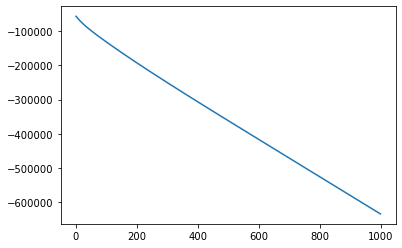

In [165]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)),losses)

In [172]:
theta = dict(pyro.get_param_store().named_parameters())['AutoDelta.theta']
beta = dict(pyro.get_param_store().named_parameters())['AutoDelta.beta']

In [167]:
pyro.get_param_store().named_parameters()

dict_items([('theta', tensor([1.0002, 1.0005, 1.0009, 1.0001, 1.0001, 1.0002, 1.0003, 1.0003, 1.0004,
        1.0004, 1.0015, 1.0000, 1.0002, 1.0004, 1.0003, 1.0007, 1.0002, 1.0001,
        1.0007, 1.0001, 1.0002, 1.0001, 1.0016, 1.0001, 1.0005, 1.0021, 1.0005,
        1.0000, 1.0001, 1.0002, 1.0001, 1.0001, 1.0001, 1.0002, 1.0003, 1.0001,
        1.0006, 1.0001, 1.0002, 1.0001, 1.0001, 1.0003, 1.0001, 1.0007, 1.0005,
        1.0000, 1.0004, 1.0001, 1.0005, 1.0007, 1.0005, 1.0008, 1.0004, 1.0001,
        1.0003, 1.0004, 1.0001, 1.0003, 1.0008, 1.0003, 1.0001, 1.0002, 1.0006,
        1.0005, 1.0031, 1.0009, 1.0001, 1.0000, 1.0001, 1.0001, 1.0001, 1.0001,
        1.0003, 1.0002, 1.0004, 1.0001, 1.0003, 1.0001, 1.0001, 1.0004, 1.0003,
        1.0001, 1.0007, 1.0004, 1.0002, 1.0002, 1.0009, 1.0001, 1.0002, 1.0001,
        1.0001, 1.0002, 1.0002, 1.0000, 1.0004, 1.0001, 1.0004, 1.0001, 1.0005,
        1.0002, 1.0002, 1.0003, 1.0008, 1.0000, 1.0006, 1.0001, 1.0005, 1.0000,
        1.0001, 1.

In [173]:
lambd = np.zeros(beta.shape)
for i in range(lambd.shape[0]):
    for j in range(lambd.shape[1]):
        lambd[i][j] = theta[i] * beta[i][j]
        

In [175]:
posteriors_all = []
for k in range(1000):
    posterior = np.zeros(lambd.shape)
    for i in range(lambd.shape[0]):
        for j in range(lambd.shape[1]):
            posterior[i][j] = np.random.poisson(lambd[i][j])
    posteriors_all.append(posterior)

In [170]:
posteriors_all[0].shape

(800, 199)

/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


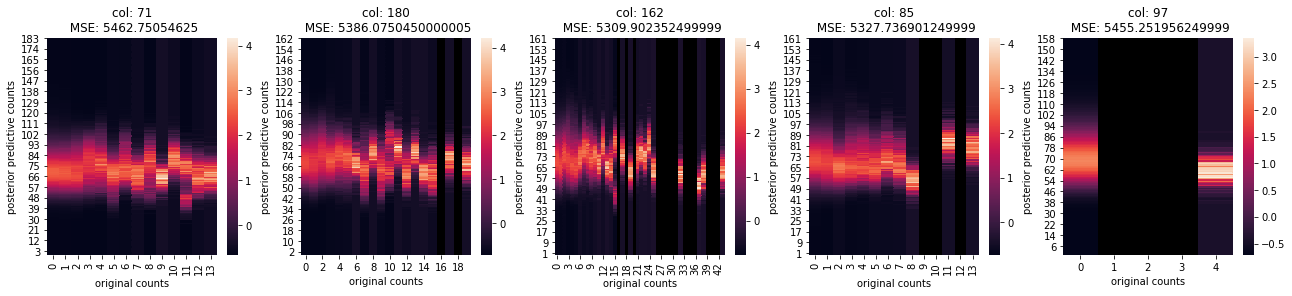

In [176]:
posteriors_all = np.asarray(posteriors_all)
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
ind = 0
rands = np.random.choice([i for i in range(200)], size=5, replace=False)
for col in rands:
    combined_x = []
    combined_y = []
    heatmap = np.zeros((int(max(posteriors_all[:, :, col].flatten())) + 1,
                        int(max(adata_subsampled.layers['counts'][:, col]))
                        + 1))
    max_post = int(max(posteriors_all[:, :, col].flatten()))
    for i in range(1000):
        combined_x.append(adata_subsampled.layers['counts'][:, col])
        combined_y.append(posteriors_all[i][:, col])
        for j in range(800):
            tmp_coord = int(adata_subsampled.layers['counts'][j, col])
            heatmap[max_post -
                    int(posteriors_all[i, j, col])][tmp_coord] += 1
    MSE = sklearn.metrics.mean_squared_error(combined_x, combined_y)
    hmap = pd.DataFrame(scipy.stats.zscore(heatmap))
    hmap.columns = [i for i in range(heatmap.shape[1])]
    hmap.index = np.flip([i for i in range(heatmap.shape[0])])
    g = sns.heatmap(hmap, ax=ax[ind])
    g.set_facecolor('black')
    g.set_xlabel("original counts")
    g.set_ylabel("posterior predictive counts")
    g.set_title("col: " + str(col) + "\n MSE: " + str(MSE))
    ind += 1